In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import classification_report

# Ładowanie danych

In [2]:
path = "scale_data/merged/"

all_files = glob.glob(path + "*")
# print(all_files)

def read_csv(f):
    return pd.read_csv(f, engine="python", delimiter="impossible_delimiter_to_read_line_by_line", names=[os.path.basename(f)])

def reset_index(df):
    df.reset_index(drop=True, inplace=True)

dataframes = [read_csv(f) for f in all_files]

df = pd.concat(dataframes, axis=1)

df.head()

,id,label_3class,label_4class,rating,subj
0,29420,0,0,0.1,"in my opinion , a movie reviewer's most import..."
1,17219,0,0,0.2,"you can watch this movie , that is based on a ..."
2,18406,0,0,0.2,"this is asking a lot to believe , and though i..."
3,18648,0,0,0.2,no heroes and no story are the main attributes...
4,20021,0,0,0.2,"this is not an art movie , yet i saw it an art..."


# Analiza danych
## Rozkład ocen

,label_3class,counts
0,0,1197
1,1,1915
2,2,1894


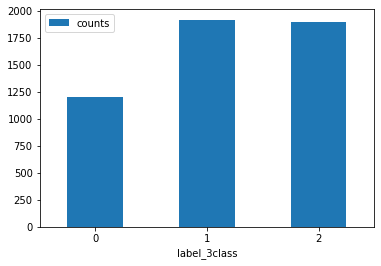

In [3]:
c = df.groupby('label_3class').size().reset_index(name='counts')
c.plot.bar(x='label_3class', y="counts", rot=0)
c

,label_4class,counts
0,0,615
1,1,1553
2,2,1998
3,3,840


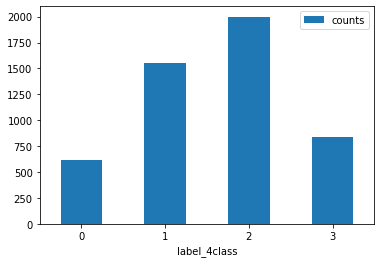

In [4]:
c = df.groupby('label_4class').size().reset_index(name='counts')
c.plot.bar(x='label_4class', y="counts", rot=0)
c

## Typowe długości recenzji

In [5]:
subj_len_list = df.subj.map(len)

print('Przeciętna długość recenzji: ' + str(subj_len_list.mean()))

subj_len_list.reset_index(name='len')[['len']].groupby('len').size().T.sort_values(ascending=False).head(15).reset_index(name='count')

Przeciętna długość recenzji: 2256.4578505793047


,len,count
0,2414,8
1,1717,8
2,2146,7
3,2786,7
4,2726,6
5,2152,6
6,2420,6
7,3013,6
8,1473,6
9,1703,6


## Średnie długości recenzji na ocenę

<AxesSubplot:xlabel='label_3class'>

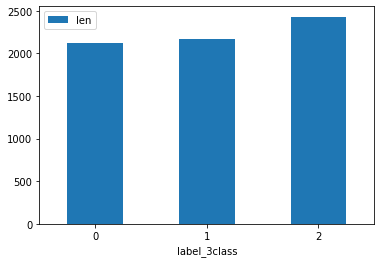

In [6]:
subj_len_df = df.copy()
subj_len_df['len'] = subj_len_df.subj.map(len)
c = subj_len_df[['label_3class','len']].groupby('label_3class').mean()
c.plot.bar(rot=0)

## Najczęściej występujące słowa:

### Wszystkie:

In [7]:
all_data_cv = CountVectorizer()
words_counts = all_data_cv.fit_transform(df.subj)
print('Różnych słów: ' + str(len(words_counts.toarray()[0])))
counts = pd.DataFrame(words_counts.toarray(),
                      columns=all_data_cv.get_feature_names())
counts.sum().T.sort_values(ascending=False).head(15).reset_index(name='counts')

Różnych słów: 41932


,index,counts
0,the,112685
1,of,55778
2,and,48379
3,to,44245
4,is,39599
5,it,32405
6,in,28737
7,that,25740
8,for,18343
9,as,17585


### Używając stop_words

In [8]:
all_data_cv = CountVectorizer(stop_words='english')
words_counts = all_data_cv.fit_transform(df.subj)
print('Różnych słów: ' + str(len(words_counts.toarray()[0])))
counts = pd.DataFrame(words_counts.toarray(),
                      columns=all_data_cv.get_feature_names())
counts.sum().T.sort_values(ascending=False).head(15).reset_index(name='counts')

Różnych słów: 41631


,index,counts
0,film,17304
1,movie,9601
2,like,6194
3,story,5363
4,director,3954
5,just,3849
6,time,3845
7,films,3453
8,characters,3240
9,good,3170


# System do maszynowego uczenia

In [9]:
subj_len_df = df.copy()
subj_len_df['len'] = subj_len_df.subj.map(len)

# X_data = subj_len_df[['subj', 'len']]
X_data = subj_len_df[['subj']]
y_data = subj_len_df.label_3class

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)

In [10]:
v = CountVectorizer(stop_words='english')
X_train_count = v.fit_transform(X_train.subj.values)

In [11]:
X_test_count = v.transform(X_test.subj)

In [12]:
# print(X_train.head())
# print(X_train_count)
# print(type(X_test_count))
# print(pd.DataFrame.sparse.from_spmatrix(X_test_count))
# print(X_data.len.values)

In [13]:
model = MultinomialNB()
model.fit(X_train_count, y_train)

MultinomialNB()

In [14]:
model.predict(X_test_count)

array([0, 1, 1, ..., 2, 0, 2], dtype=int64)

In [15]:
model.score(X_test_count, y_test)

0.6190095846645367

In [16]:
clf = svm.SVC()
clf.fit(X_train_count, y_train)

SVC()

In [17]:
predictions = clf.predict(X_test_count)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.34      0.47       291
           1       0.54      0.71      0.61       480
           2       0.72      0.71      0.71       481

    accuracy                           0.63      1252
   macro avg       0.66      0.59      0.60      1252
weighted avg       0.65      0.63      0.62      1252



In [18]:
clf.score(X_test_count, y_test)

0.6261980830670927

In [19]:
scores = cross_val_score(model, X_train_count, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print(scores)
print(scores.mean())

[0.63031915 0.62234043 0.59840426 0.61702128 0.64       0.62666667
 0.63466667 0.62133333 0.66133333 0.61066667]
0.6262751773049645


In [20]:
scores = cross_val_score(clf, X_train_count, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print(scores)
print(scores.mean())

[0.62765957 0.66489362 0.63031915 0.6037234  0.656      0.63733333
 0.64266667 0.60533333 0.63733333 0.61333333]
0.631859574468085


# Raport eksperymentów

Wszystkie badania prowadzone są w kontekście zbioru danych `scale_data`

## Najlepsze wartości parametrów dla algorytmu SVM

Celem badania jest znalezienie najlepszych parametrów dla algorytmu SVM używając kernela `rbf`

In [21]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1)
grid.fit(X_train_count, y_train)

print(grid.best_params_)
print(grid.best_estimator_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.001)


In [22]:
grid_predictions = grid.predict(X_test_count)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.64      0.54      0.59       291
           1       0.56      0.64      0.60       480
           2       0.76      0.72      0.74       481

    accuracy                           0.65      1252
   macro avg       0.65      0.63      0.64      1252
weighted avg       0.65      0.65      0.65      1252



#### Wniosek
Najlepszymi parametrami wynikającymi z badania są:

`C`: 10

`gamma`: 0.001

## Wrażliwość hiperparametrów na testowane algorytmy

Celem badania jest analiza wpływu zmian parametru `alfa` w algorytmie Bayesa.

In [23]:
alpha_range = list(map(lambda x: x / 10, range(1, 51)))
param_grid = dict(alpha=alpha_range)
grid = GridSearchCV(MultinomialNB(), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_count, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                                   1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
                                   2.8, 2.9, 3.0, ...]},
             scoring='accuracy')

Text(0, 0.5, 'Accuracy')

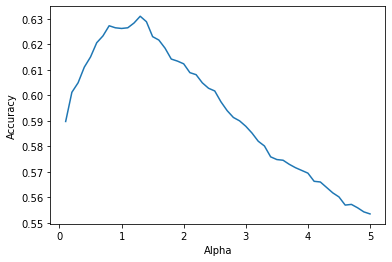

In [26]:
results = grid.cv_results_['mean_test_score']
plt.plot(alpha_range, results)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")

#### Wniosek
Najlepszy rezultat daje ustawienie parametru Alfa na nieco ponad 1. 

## Istotność selekcji cech

Celem badania jest porównanie wyników użycia wszystkich słów jako cechy i pominięcia niektórych z nich używając `stop words` dla algorytmów Bayesa i SVM

In [37]:
v = CountVectorizer()
X = v.fit_transform(X_data.subj.values)

vs = CountVectorizer(stop_words='english')
Xs = vs.fit_transform(X_data.subj.values)

### Bayes

In [38]:
grid = GridSearchCV(MultinomialNB(), param_grid, cv=10, scoring='accuracy', n_jobs=-1)

In [39]:
grid.fit(X, y_data)
x_best = grid.best_score_

grid.fit(Xs, y_data)
xs_best = grid.best_score_

0.5787176894961327
0.5807222717402357


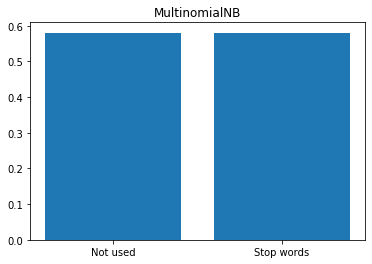

In [49]:
print(x_best)
print(xs_best)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(
    ['Not used', 'Stop words'],
    [x_best, xs_best]
)

plt.title("MultinomialNB")
plt.show()

### SVM

In [42]:
grid = GridSearchCV(svm.SVC(), {'C': [10], 'gamma': [0.001], 'kernel': ['rbf']}, refit=True, verbose = 3, n_jobs=-1)

In [43]:
grid.fit(X, y_data)
x_best = grid.best_score_

grid.fit(Xs, y_data)
xs_best = grid.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [44]:
print(x_best)
print(xs_best)

0.5787176894961327
0.5807222717402357


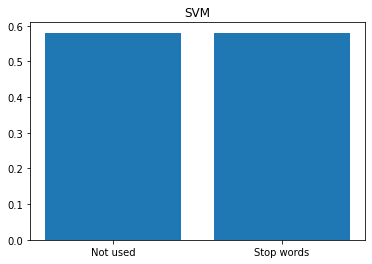

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(
    ['Not used', 'Stop words'],
    [x_best, xs_best]
)

plt.title("SVM")
plt.show()

#### Wniosek
Użycie stop_words ma niewielki wpływ na wynik.

## Analiza wielkości podzbioru walidacyjnego

Celem badania jest analiza wpływu wielkości podziału walidacji krzyżowej na wyniki.

In [45]:
scores = []
for n in range(2, 10):
    grid = GridSearchCV(MultinomialNB(), dict(), cv=n, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y_data)
    scores.append(grid.best_score_)

Text(0, 0.5, 'Best score')

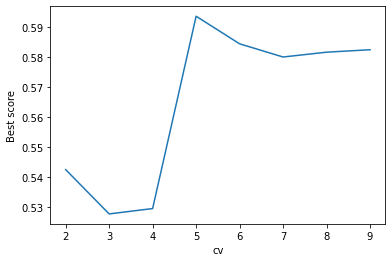

In [46]:
plt.plot(range(2, 10), scores)
plt.xlabel("cv")
plt.ylabel("Best score")

#### Wniosek
Najlepszy wynik można uzyskać dzieląc zbiór na 5 części.

## Analiza wielkości ngramów

Celem badania jest analiza wpływu wielkości ngramów na wyniki.

In [47]:
ngram_ranges = [(1, 1), (1, 2), (1,3)]
scores = []
for nr in ngram_ranges:
    cv = CountVectorizer(stop_words = 'english', ngram_range = nr)
    X = cv.fit_transform(X_data.subj.values)
    grid = GridSearchCV(MultinomialNB(), dict(), cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y_data)
    scores.append(grid.best_score_)

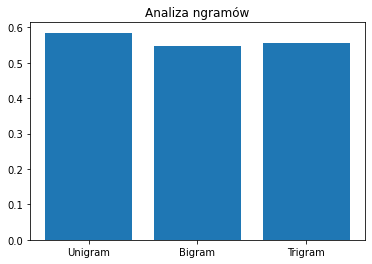

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(
    ['Unigram', 'Bigram', 'Trigram'],
    [scores[0], scores[1], scores[2]])

plt.title("Analiza ngramów")
plt.show()

#### Wniosek
Najlepszy wynik można uzyskać dla domyślnego unigramu.